In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import random

np.random.seed(123)
import numpy as np
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import tensorflow as tf
import NES
from eikonalfm import factored_fast_marching as ffm
from eikonalfm import distance

2023-06-15 09:56:59.130338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-15 09:56:59.130491: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Velocity Field with a Vertical Gradient


In [91]:
v0 = 2.
vergrad = 0.5
horgrad = 0.
zmin = 0.;zmax=2.;deltaz=0.02;
xmin = 0.;xmax = 2.;deltax = 0.02;

sz = 0
sx = 0

z = np.arange(zmin,zmax+deltaz,deltaz);
nz = z.size

x = np.arange (xmin,xmax+deltax,deltax);
nx = x.size

Z,X = np.meshgrid (z,x,indexing = 'ij')

vs = v0 + vergrad*sz +horgrad*sx ;
velmodel = vs + vergrad*(Z-sz) + horgrad*(X-sx);

if vergrad == 0 and horgrad == 0:
    T_data = np.sqrt (Z-sz)**2 + (X-sx)**2 / v0;
else:
    T_data = np.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(vergrad**2 + horgrad**2)*((X-sx)**2 + (Z-sz)**2))/np.sqrt(vergrad**2 + horgrad**2)
    

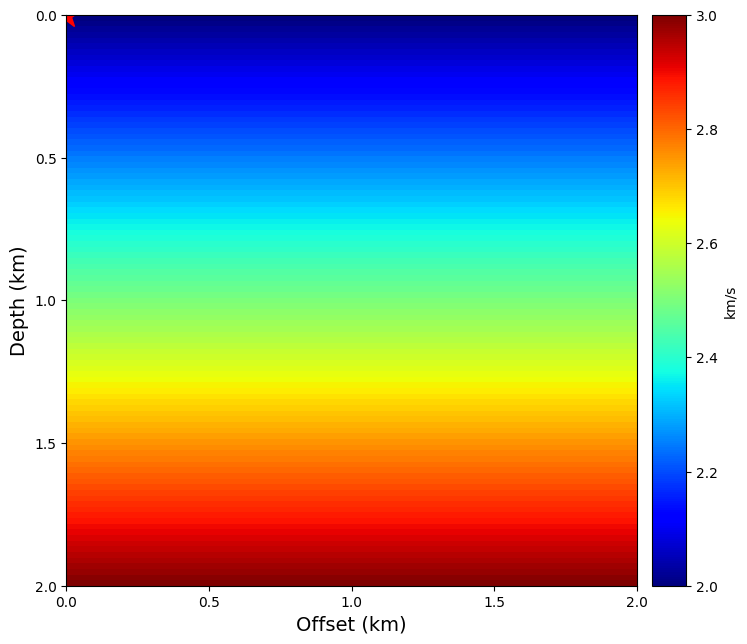

In [47]:
# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(8,8))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")

ax.plot(sx,sz,'r*',markersize=20)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)



In [92]:
Vel = NES.Interpolator (velmodel,x,z)

In [93]:
Xr = np.stack((X,Z),axis=-1)
s_sp = 5
Xs = np.stack(np.meshgrid(x[::s_sp],z[::s_sp],indexing='ij'),axis=-1)
Xt = np.stack(np.meshgrid(x[::s_sp], z[::s_sp], x, z, indexing='ij'), axis=-1)

In [94]:

T_ref = np.empty(Xs.shape[:-1] + Xr.shape[:-1])
dxs = [x[1]-x[0], z[1]-z[0]]
for i, ixs in enumerate(tqdm(range(0, nx, s_sp))):
    for j, jzs in enumerate(range(0, nz, s_sp)):
        T_ref[i,j] = ffm(velmodel, (ixs,jzs), dxs, 2)
        T_ref[i,j] *= distance(velmodel.shape, dxs, (ixs,jzs), indexing='ij')

  0%|          | 0/21 [00:00<?, ?it/s]

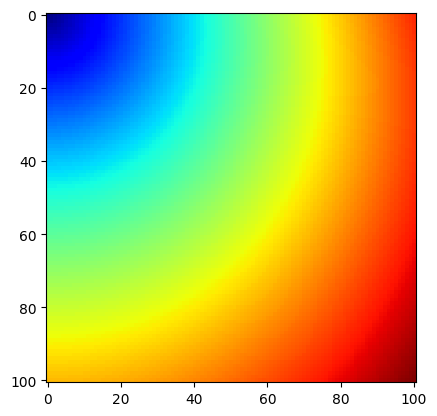

In [95]:
plt.imshow (T_data,cmap = 'jet')

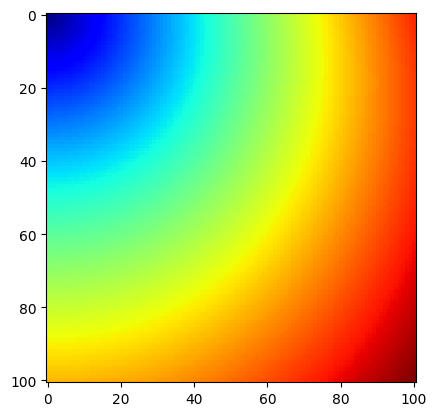

In [96]:
plt.imshow (T_ref[0,0,:,:],cmap='jet')

# NES TP Initialization and Training


In [97]:
eikonal = NES.IsoEikonal(p=2, hamiltonian = True)

#Initialization

Eik =NES.NES_TP(velocity = Vel, eikonal = eikonal)

#build neural network model
tf.keras.backend.clear_session()

Eik.build_model(nl = 4, nu=70,act = 'ad-gauss-1',out_act='ad-sigmoid-1',
               input_scale=True,factored=True,out_vscale=True,
               reciprocity=True)

In [98]:
Eik.compile(optimizer=None,
           loss='mae',
           lr = 0.03,
            decay=0.0005)

In [99]:
%%time
num_pts = 20000
h = Eik.train(x_train=num_pts, # number of random colocation points for training
              tolerance=2e-3, # tolerance value for early stopping (expected error with 2nd-order f-FMM)
              epochs=2000,
              verbose=0,
              callbacks=[TqdmCallback(verbose=0, miniters=10, mininterval=5)], # progress bar
              batch_size=int(num_pts/4),
              )

0epoch [00:00, ?epoch/s]

Epoch 00204: early stopping
loss: 0.00248
Approximate RMAE of solution: 0.17154 %
CPU times: user 4min 53s, sys: 1min 4s, total: 5min 58s
Wall time: 44.4 s


In [100]:
T = Eik.Traveltime(Xt)

45/45 [==============================] - 6s 130ms/step


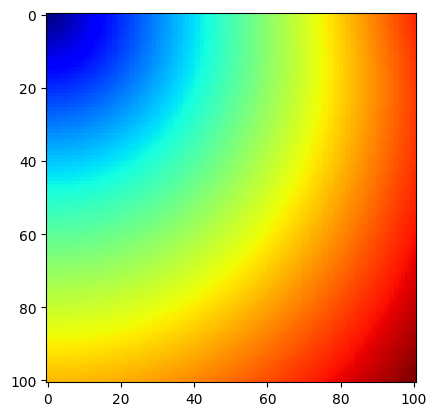

In [101]:
plt.imshow(T[0,0,:,:],cmap = 'jet')

# Initial Model

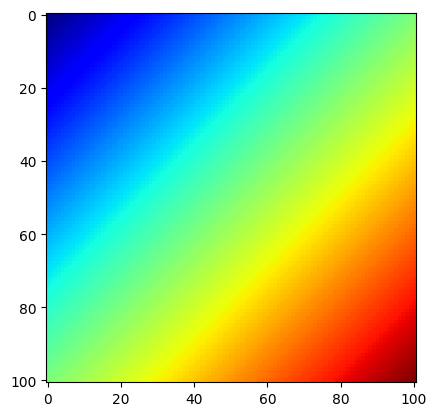

In [104]:
v_ini = vs + (Z-sz) + (X-sx);
Vel_ini = NES.Interpolator (v_ini,x,z);
 
plt.imshow(v_ini,cmap='jet')

In [108]:
Eik2 = NES.NES_TP(velocity=Vel_ini, # velocity model (see NES.Interpolator)
                 eikonal=eikonal # optional, by default isotropic eikonal equation
                 )
Eik2.build_model(nl=4, # number of layers
                nu=70, # number of units (may be a list)
                act='ad-gauss-1', # acivation funciton ('ad' means adaptive, '1' means slope scale)
                out_act='ad-sigmoid-1', # output activation, 'sigmoid' stands for improved factorization
                input_scale=True, # inputs scaling
                factored=True, # factorization
                out_vscale=True, # constraining by the slowest and the fastest solutions
                reciprocity=True, # symmetrizaion for the reciprocity principle 
                )

In [110]:
%%time
num_pts = 20000
h2 = Eik2.train(x_train=num_pts, # number of random colocation points for training
              tolerance=2e-3, # tolerance value for early stopping (expected error with 2nd-order f-FMM)
              epochs=2000,
              verbose=0,
              callbacks=[TqdmCallback(verbose=0, miniters=10, mininterval=5)], # progress bar
              batch_size=int(num_pts/4),
              )

0epoch [00:00, ?epoch/s]

Epoch 00440: early stopping
loss: 0.00245
Approximate RMAE of solution: 0.16965 %
CPU times: user 10min 33s, sys: 2min 30s, total: 13min 3s
Wall time: 1min 36s


In [112]:
T2 = Eik2.Traveltime(Xt)

45/45 [==============================] - 6s 128ms/step


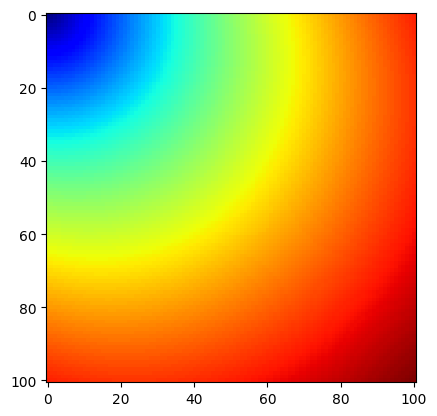

In [114]:
plt.imshow(T2[0,0,:,:],cmap = 'jet')

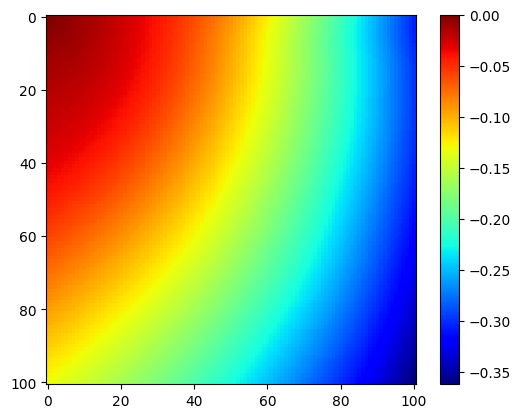

In [116]:
plt.imshow(T2[0,0,:,:]-T[0,0,:,:],cmap = 'jet')
plt.colorbar()

In [135]:
eikonal_loss = Eik2.model(V)


NameError: name 'V' is not defined